# Import librairies

In [1]:
# Import main librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import librairies to connect to the database
import psycopg2 as ps
import pandas.io.sql as sqlio

# Import Classifier
from sklearn.tree import DecisionTreeClassifier

# Import tools
%run ../Tools.ipynb

# Connect to database

In [2]:
conn = ps.connect(dbname="SLA", user="postgres", password="root", host="localhost", port="5432")

# Get data from database

In [3]:
# Set variables
variables = ['WEIGHT_VAR_M9', 'GROUPEDEB']

# Set sql query
sql = 'SELECT * FROM "PATIENTS"'

# Get data from database
df_patients = sqlio.read_sql_query(sql, conn)[variables].copy()
print("Nombre de patients restant :", df_patients.shape[0])

Nombre de patients restant : 1045


C:\Users\guill\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# Drop null values

In [4]:
# Drop null values
df_patients = df_patients.dropna().copy()
print("Nombre de patients restant :", df_patients.shape[0])

Nombre de patients restant : 282


# Drop "Respiratoire" Diagnostic

In [5]:
df_patients = df_patients[df_patients.GROUPEDEB != "Respiratoire"]
print("Nombre de patients restant :", df_patients.shape[0])

Nombre de patients restant : 278


# Separate features and target

In [6]:
# Get features
X = df_patients.drop(df_patients.columns.values[-1], axis=1)

# Get target
y = df_patients[df_patients.columns.values[-1]]

# Encode categorical data

In [7]:
X = encodeData(X)

# Execute Decision Tree Classifier

## Set up

In [8]:
# Set test size
test_size = 0.2

# Set number of iterations
n_repeats = 100

# Set number of splits
n_splits = 5

# Set max depth
depth = 1

# Criterion
criterion = "gini"

# Use of Cross-Validation
useCrossValidation = False

# Use of Oversampling
global useSmote, useBorderlineSMOTE, useSVMSMOTE, useKMeansSMOTE
useSmote = False; useBorderlineSMOTE = False; useSVMSMOTE = False; useKMeansSMOTE = False

# Use of Undersampling
global useNearMiss, useCondensedNearestNeighbour, useTomekLinks, useEditedNearestNeighbours, useOneSidedSelection
useNearMiss = False; useCondensedNearestNeighbour = False; useTomekLinks = False; 
useEditedNearestNeighbours = False; useOneSidedSelection = False

# Sampling parameters
global n_neighbors, sampling_strategy, NearMiss_version, n_seeds_S
n_neighbors = 5; sampling_strategy = 1; NearMiss_version = 3; n_seeds_S = 105

## Execute classifier

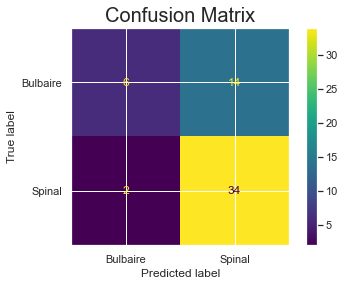

accuracy : 0.7142857142857143
recall : 0.9444444444444444
Fmeasure : 0.813397129186603


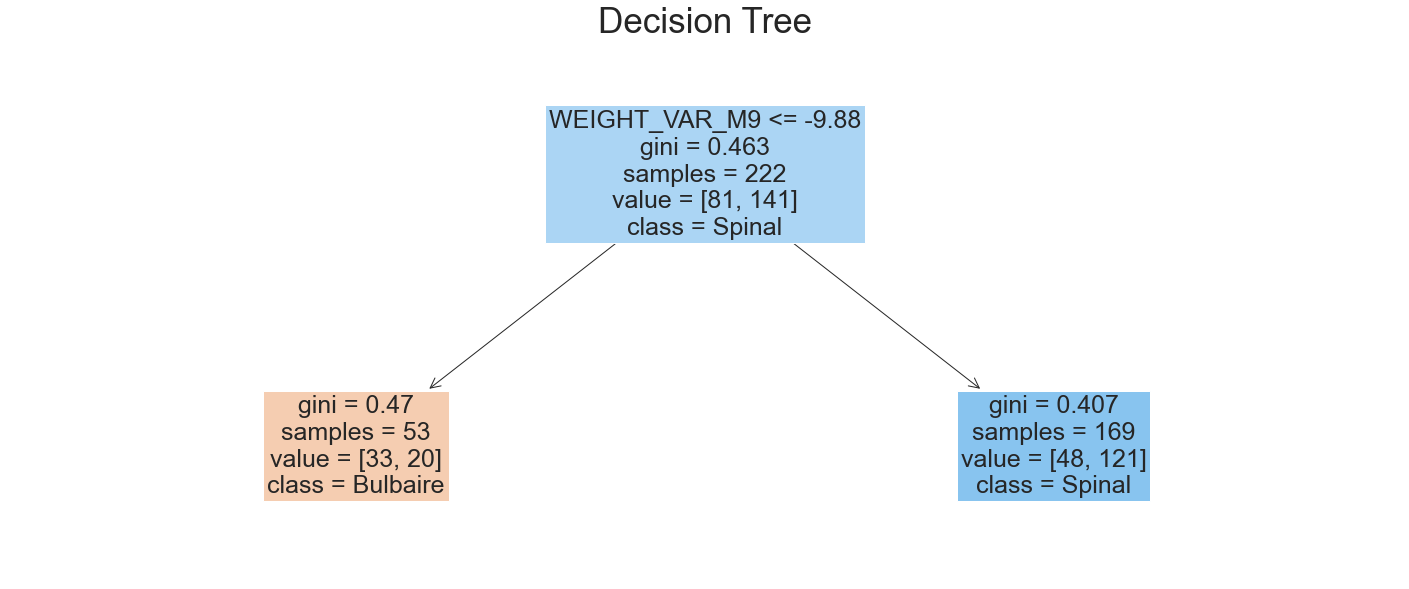

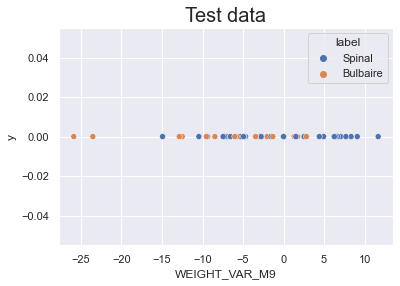

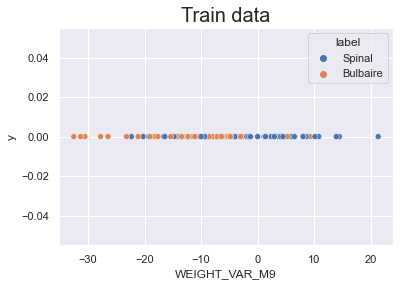

In [9]:
# If no use of cross Validation
if useCrossValidation == False:
    
    # Execute classifier
    clf = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
    accuracies, recalls, Fmeasures, left_class_nb, right_class_nb, left_class_fit, right_class_fit = binaryClassifier(clf, X, y, test_size, n_repeats, True)
    
# If use of cross Validation
else:

    # Store temporary target and features
    X_tmp = X.copy()
    y_tmp = y.copy()


    # Map target labels to 1 or 0
    y_tmp = y_tmp.map({'Spinal': 1, 'Bulbaire': 0}).astype(int)
    
    # Set Classifier
    clf = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
    
    # Execute Cross-Validation
    accuracies, recalls, Fmeasures = crossValidationBinaryClassifier(clf, X_tmp, y_tmp, test_size, n_repeats)
    
# Compute averaged metrics
avg_accuracy = np.mean(accuracies)
avg_recall = np.mean(recalls)
avg_Fmeasure = np.mean(Fmeasures)
avg_left_class_nb = np.mean(left_class_nb)
avg_right_class_nb = np.mean(right_class_nb)
# Compute standard deviation
std_accuracy = np.std(accuracies)
std_recall = np.std(recalls)
std_Fmeasure = np.std(Fmeasures)
std_left_class_nb = np.std(left_class_nb)
std_right_class_nb = np.std(right_class_nb)

## Plot classifier metrics results

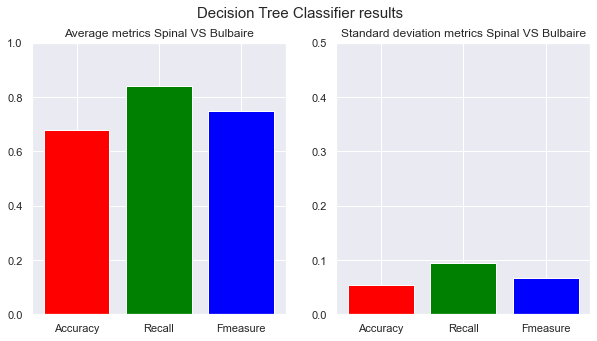

In [10]:
# Add subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Define metric colors
color = ['red', 'green', 'blue']

# Define Text title
title = 'Decision Tree Classifier results '
if useCrossValidation:
    title += 'Using Cross Validation '

plt.suptitle(title, fontsize=15)

# Plot averaged metrics on the first axis
ax1.bar(["Accuracy", "Recall", "Fmeasure"], [avg_accuracy, avg_recall, avg_Fmeasure], color=color)
ax1.set_title("Average metrics Spinal VS Bulbaire")
ax1.set_ybound(upper=1)

# Plot standard deviations metrics on the second axis
ax2.bar(["Accuracy", "Recall", "Fmeasure"], [std_accuracy, std_recall, std_Fmeasure], color=color)
ax2.set_title("Standard deviation metrics Spinal VS Bulbaire")
ax2.set_ybound(upper=0.5)

plt.show()

## Plot confusion matrix sample number results

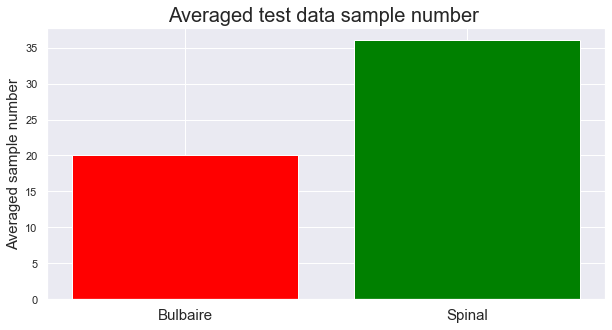

Standard deviation sample number 0.0


In [11]:
# Add subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

# Define metric colors
color = ['red', 'green']

# Define Text title
title = 'Averaged test data sample number '
if useCrossValidation:
    title += 'Using Cross Validation '

plt.title(title, fontsize=20)

# Plot averaged class sample on the first axis
ax1.bar([clf.classes_[0], clf.classes_[1]], [avg_left_class_nb, avg_right_class_nb], color=color)
ax1.set_ylabel("Averaged sample number", fontsize=15)
ax1.tick_params(axis='x', labelsize=15)
plt.show()

# Display standard deviations class sample on the second axis
print("Standard deviation sample number", round(std_right_class_nb, ndigits=2))

# Execute Decision Tree Classifier based on differents depths

## Set up

In [12]:
# Set lits for all averaged metrics
avg_accuracies = []
avg_recalls = []
avg_Fmeasures = []
avg_left_class_fit = []
avg_right_class_fit = []

# Set lists for all std metrics
std_accuracies = []
std_recalls = []
std_Fmeasures = []
std_left_class_fit = []
std_right_class_fit = []

depths = []

start_depth = 1
end_depth = 10

# Set test size
test_size = 0.2

# Set number of iterations
n_repeats = 100

# Set number of splits
n_splits = 10

# Criterion
criterion = "gini"

# Use of cross Validation
useCrossValidation = False

# Use of Oversampling
global useSmote, useBorderlineSMOTE, useSVMSMOTE, useKMeansSMOTE
useSmote = False; useBorderlineSMOTE = False; useSVMSMOTE = False; useKMeansSMOTE = False

# Use of Undersampling
global useNearMiss, useCondensedNearestNeighbour, useTomekLinks, useEditedNearestNeighbours, useOneSidedSelection
useNearMiss = False; useCondensedNearestNeighbour = False; useTomekLinks = False; 
useEditedNearestNeighbours = False; useOneSidedSelection = False

# Sampling parameters
global n_neighbors, sampling_strategy, NearMiss_version, n_seeds_S
n_neighbors = 20; sampling_strategy = 1; NearMiss_version = 3; n_seeds_S = 120

## Execute classifier

In [13]:
# For each depth
for i in range(start_depth, end_depth + 1):

    # Add next depth into the array
    depths.append(i)

    # If no use of cross Validation
    if useCrossValidation == False:

        # Execute classifier
        clf = DecisionTreeClassifier(max_depth=i, criterion=criterion)
        accuracies, recalls, Fmeasures, left_class_fit, right_class_fit, left_class_fit, right_class_fit = binaryClassifier(clf, X, y, test_size, n_repeats, False)

    # If use of cross Validation
    else:

        # Store temporary target and features
        X_tmp = X.copy()
        y_tmp = y.copy()

        # Map target labels to 1 or 0
        y_tmp = y_tmp.map({'Spinal': 1, 'Bulbaire': 0}).astype(int)

        # Set Classifier
        clf = DecisionTreeClassifier(max_depth=i, criterion=criterion)

        # Execute Cross-Validation
        accuracies, recalls, Fmeasures = crossValidatiofitinaryClassifier(clf, X_tmp, y_tmp, test_size, n_repeats)

    # Compute averaged metrics
    avg_accuracy = np.mean(accuracies)
    avg_recall = np.mean(recalls)
    avg_Fmeasure = np.mean(Fmeasures)
   
    avg_accuracies.append(avg_accuracy)
    avg_recalls.append(avg_recall)
    avg_Fmeasures.append(avg_Fmeasure)
    avg_left_class_fit.append(np.mean(left_class_fit))
    avg_right_class_fit.append(np.mean(right_class_fit))

    # Compute standard deviation
    std_accuracy = np.std(accuracies)
    std_recall = np.std(recalls)
    std_Fmeasure = np.std(Fmeasures)
    
    std_accuracies.append(std_accuracy)
    std_recalls.append(std_recall)
    std_Fmeasures.append(std_Fmeasure)
    std_left_class_fit.append(np.std(left_class_fit))
    std_right_class_fit.append(np.std(right_class_fit))

## Plot classifier metrics results

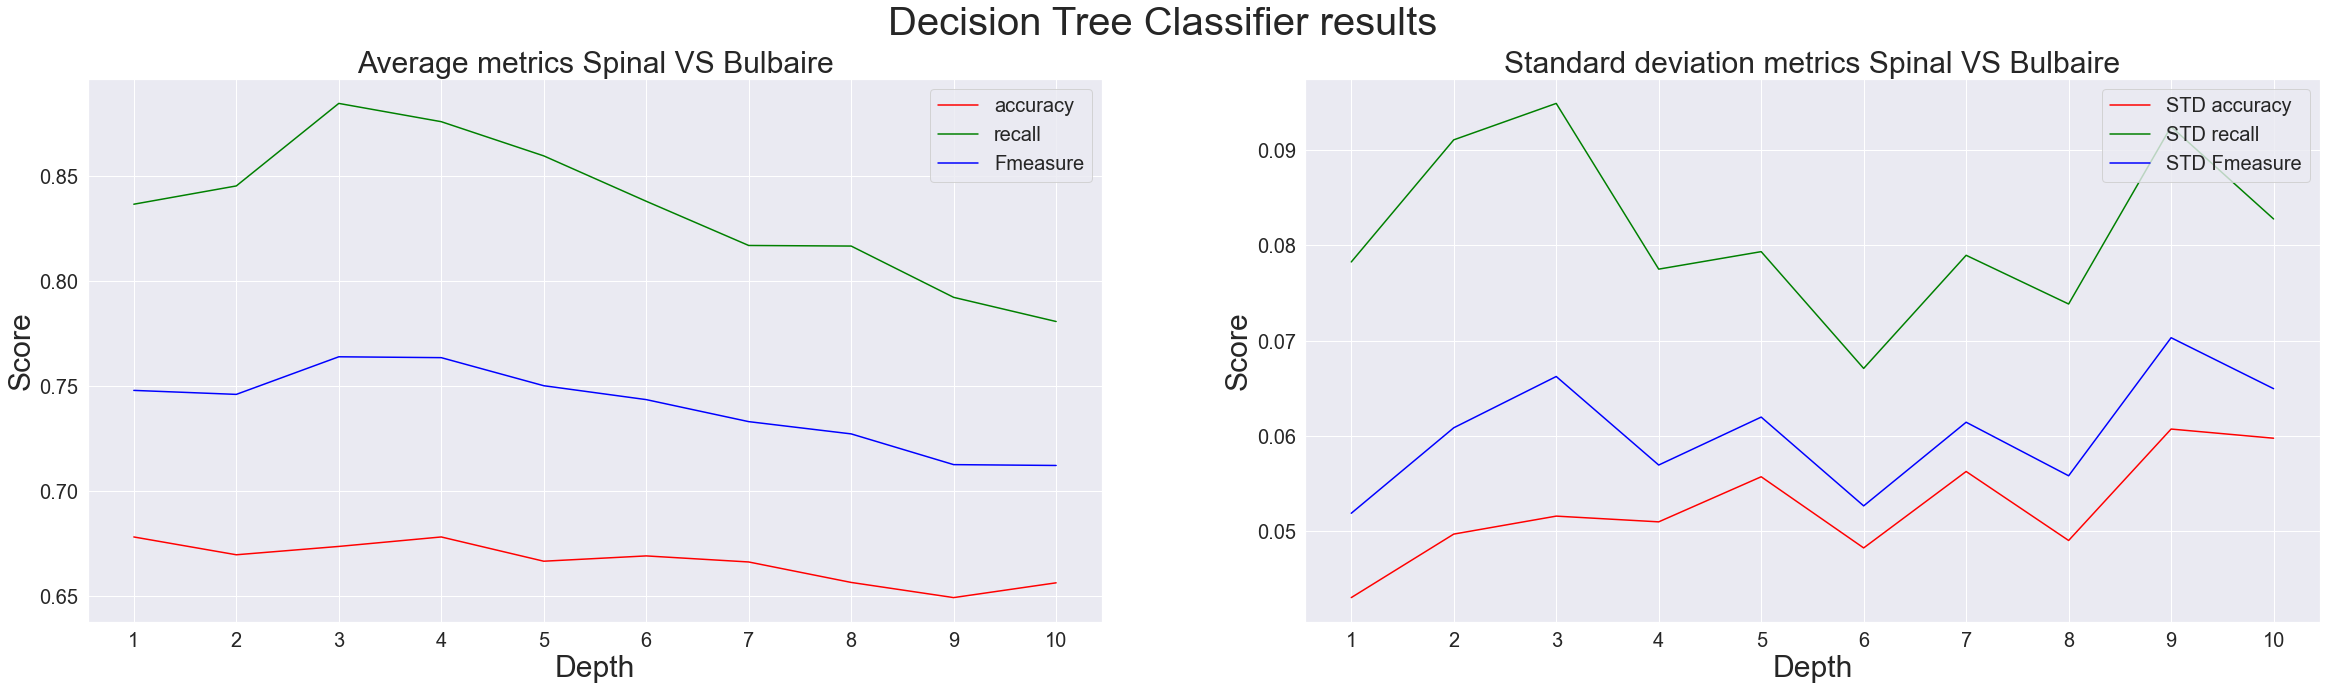

In [14]:
# Add subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10))

# Define text title
title = 'Decision Tree Classifier results ' 
if useCrossValidation:
    title += 'Using Cross Validation '

plt.suptitle(title, fontsize=40)

# Plot averaged metrics list on the first axis
ax1.plot(depths, avg_accuracies, color="red", label="accuracy")
ax1.plot(depths, avg_recalls, color="green", label="recall")
ax1.plot(depths, avg_Fmeasures, color="blue", label="Fmeasure")

ax1.legend(loc="upper right", title="", frameon=True, fontsize = 20)
ax1.set_xticks(depths)
ax1.set_xlabel("Depth", fontsize=30)
ax1.set_ylabel("Score", fontsize=30)
ax1.tick_params(axis="both", labelsize=20)
ax1.set_title("Average metrics Spinal VS Bulbaire", fontsize=30)

# Plot standard deviations metrics list on the second axis
ax2.plot(depths, std_accuracies, color="red", label="STD accuracy")
ax2.plot(depths, std_recalls, color="green", label="STD recall")
ax2.plot(depths, std_Fmeasures, color="blue", label="STD Fmeasure")

ax2.legend(loc="upper right", title="", frameon=True, fontsize = 20)
ax2.set_xticks(depths)
ax2.set_xlabel("Depth", fontsize=30)
ax2.set_ylabel("Score", fontsize=30)
ax2.tick_params(axis="both", labelsize=20)
ax2.set_title("Standard deviation metrics Spinal VS Bulbaire", fontsize=30)

plt.show()

## Plot class fit from the confusion matrix

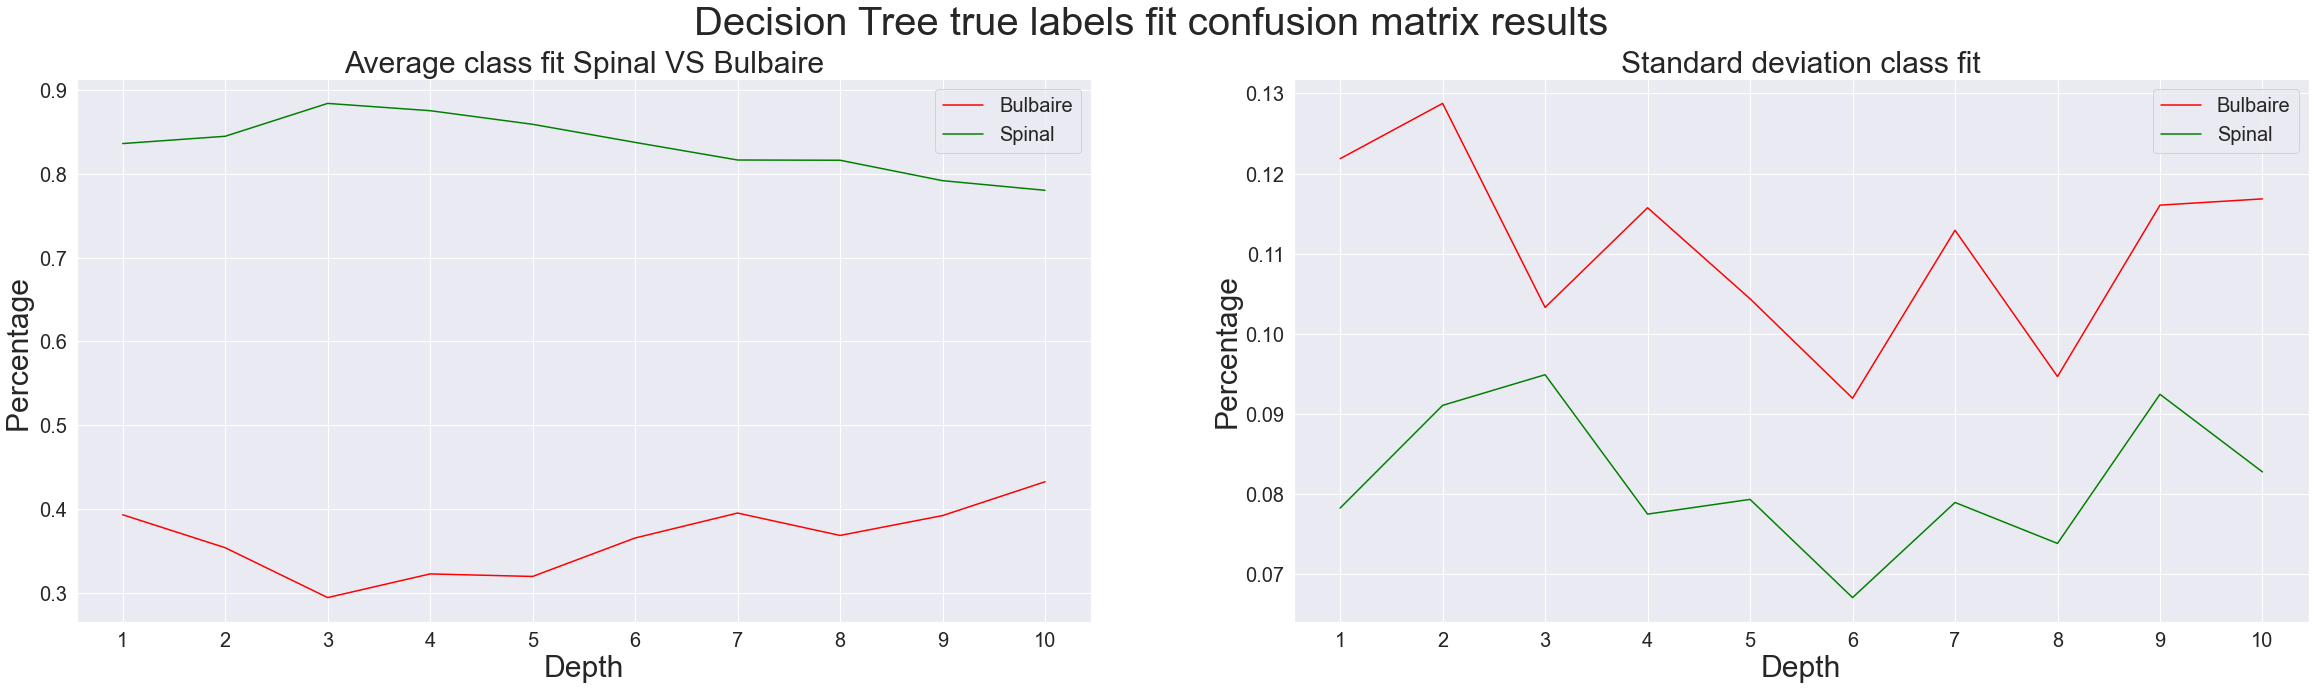

In [15]:
# Add subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10))

# Define text title
title = 'Decision Tree true labels fit confusion matrix results ' 
if useCrossValidation:
    title += 'Using Cross Validation '

plt.suptitle(title, fontsize=40)

# Plot averaged metrics list on the first axis
ax1.plot(depths, avg_left_class_fit, color="red", label=clf.classes_[0])
ax1.plot(depths, avg_right_class_fit, color="green", label=clf.classes_[1])

ax1.legend(loc="upper right", title="", frameon=True, fontsize = 20)
ax1.set_xticks(depths)
ax1.set_xlabel("Depth", fontsize=30)
ax1.set_ylabel("Percentage ", fontsize=30)
ax1.tick_params(axis="both", labelsize=20)
ax1.set_title("Average class fit Spinal VS Bulbaire", fontsize=30)

# Plot standard deviations metrics list on the second axis
ax2.plot(depths, std_left_class_fit, color="red", label=clf.classes_[0])
ax2.plot(depths, std_right_class_fit, color="green", label=clf.classes_[1])

ax2.legend(loc="upper right", title="", frameon=True, fontsize = 20)
ax2.set_xticks(depths)
ax2.set_xlabel("Depth", fontsize=30)
ax2.set_ylabel("Percentage", fontsize=30)
ax2.tick_params(axis="both", labelsize=20)
ax2.set_title("Standard deviation class fit", fontsize=30)

plt.show()